# Detecção de Transações Fraudulentas

Este notebook aborda o problema de detecção de transações fraudulentas utilizando aprendizado de máquina. O objetivo é desenvolver um modelo capaz de prever se uma transação é fraude ou não, utilizando o conjunto de dados `databaseFraude.csv`.

## Etapas do Estudo de Caso
1. **Análise Exploratória de Dados (EDA):** Exploração gráfica e tabular dos dados.
2. **Modelagem Preditiva:** Construção de modelos utilizando KNN, Árvore de Decisão e Regressão Logística, com comparação de resultados.
3. **Importância das Features:** Identificação das variáveis mais relevantes para a detecção de fraudes.
4. **Métricas de Avaliação:** Apresentação de matriz de confusão, acurácia, precisão e recall.
5. **Ajustes e Melhorias:** Ajuste de hiperparâmetros para melhorar o desempenho do modelo.

## 1. Importação de Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

## 2. Carregamento e Pré-visualização dos Dados

In [2]:
# Carregar o conjunto de dados
data = pd.read_csv('../data/databaseFraude.csv')

# Reduzir o tamanho do conjunto de dados para uma amostra
data = data.sample(frac=0.1, random_state=42)  # Usa apenas 10% dos dados

# Visualizar as primeiras linhas
display(data.head())

# Informações gerais sobre o conjunto de dados
data.info()

# Verificar valores nulos
print("\nValores nulos por coluna:")
print(data.isnull().sum())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 636262 entries, 3737323 to 759063
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            636262 non-null  int64  
 1   type            636262 non-null  object 
 2   amount          636262 non-null  float64
 3   nameOrig        636262 non-null  object 
 4   oldbalanceOrg   636262 non-null  float64
 5   newbalanceOrig  636262 non-null  float64
 6   nameDest        636262 non-null  object 
 7   oldbalanceDest  636262 non-null  float64
 8   newbalanceDest  636262 non-null  float64
 9   isFraud         636262 non-null  int64  
 10  isFlaggedFraud  636262 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 58.3+ MB

Valores nulos por coluna:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0


## 3. Análise Exploratória de Dados (EDA)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,636262.000000,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,6.362620e+05,636262.000000,636262.000000
mean,243.527333,1.810421e+05,8.285452e+05,8.499065e+05,1.106790e+06,1.232760e+06,0.001284,0.000002
std,142.493187,6.136867e+05,2.877271e+06,2.913449e+06,3.396119e+06,3.685490e+06,0.035811,0.001254
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,156.000000,1.336292e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,239.000000,7.494935e+04,1.411181e+04,0.000000e+00,1.330480e+05,2.159363e+05,0.000000,0.000000
75%,335.000000,2.094772e+05,1.069565e+05,1.436672e+05,9.505290e+05,1.119455e+06,0.000000,0.000000
max,742.000000,6.933732e+07,3.791982e+07,3.795009e+07,3.279981e+08,3.284317e+08,1.000000,1.000000


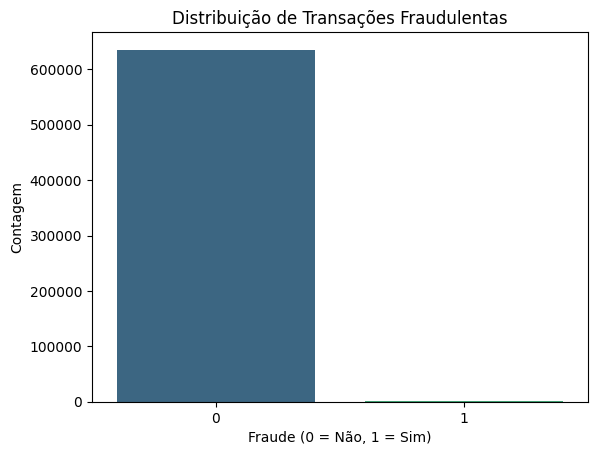

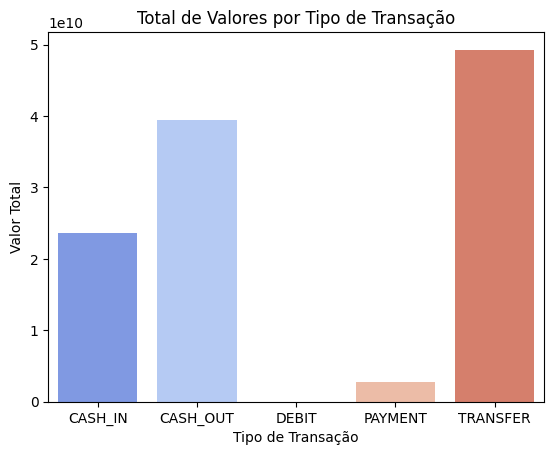

In [3]:
# Resumo estatístico
display(data.describe())

# Distribuição de transações fraudulentas
sns.countplot(x='isFraud', data=data, palette='viridis')
plt.title('Distribuição de Transações Fraudulentas')
plt.xlabel('Fraude (0 = Não, 1 = Sim)')
plt.ylabel('Contagem')
plt.show()

# Total de valores por tipo de transação
aggregated_data = data.groupby('type')['amount'].sum().reset_index()
sns.barplot(x='type', y='amount', data=aggregated_data, palette='coolwarm')
plt.title('Total de Valores por Tipo de Transação')
plt.xlabel('Tipo de Transação')
plt.ylabel('Valor Total')
plt.show()

## 4. Pré-processamento dos Dados

In [4]:
# Codificação de variáveis categóricas
data['type'] = data['type'].replace({'PAYMENT': 1, 'TRANSFER': 2, 'CASH_OUT': 3, 'CASH_IN': 4, 'DEBIT': 5})

# Remoção de colunas irrelevantes
data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# Separação entre variáveis independentes (X) e dependente (y)
X = data.drop('isFraud', axis=1)
y = data['isFraud']

# Divisão dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalização das variáveis independentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 5. Modelagem Preditiva

In [5]:
# Modelo KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

# Modelo Árvore de Decisão
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# Modelo Regressão Logística
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

## 6. Importância das Features

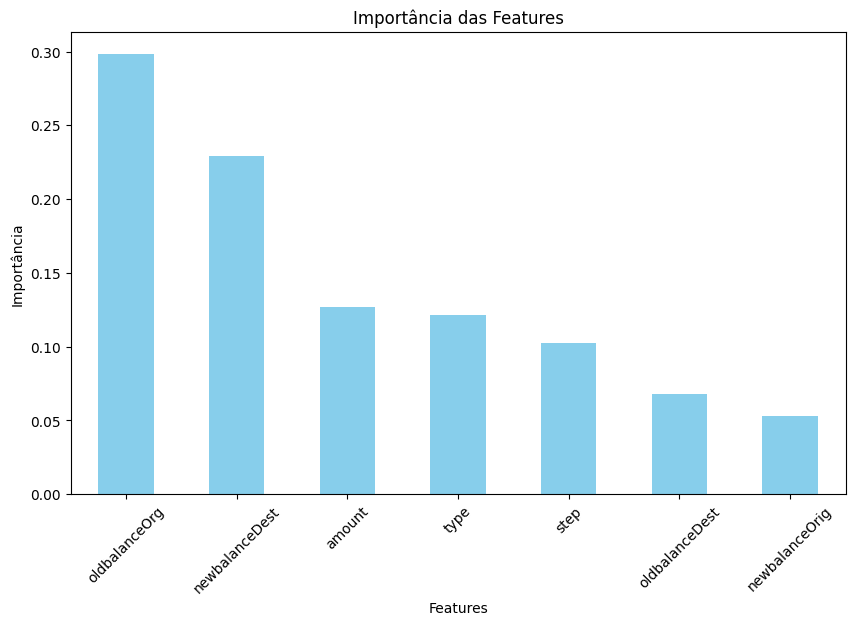

In [6]:
# Modelo Random Forest para análise de importância
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Extração das importâncias
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Importância das Features')
plt.xlabel('Features')
plt.ylabel('Importância')
plt.xticks(rotation=45)
plt.show()

## 7. Métricas de Avaliação

In [7]:
# Função para exibir métricas
def avaliar_modelo(y_test, y_pred, nome_modelo):
    print(f"\nModelo: {nome_modelo}")
    print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred):.4f}")
    print("Matriz de Confusão:")
    print(confusion_matrix(y_test, y_pred))

# Avaliação dos modelos
avaliar_modelo(y_test, y_pred_knn, 'KNN')
avaliar_modelo(y_test, y_pred_tree, 'Árvore de Decisão')
avaliar_modelo(y_test, y_pred_logreg, 'Regressão Logística')


Modelo: KNN
Acurácia: 0.9992
Precisão: 0.9868
Recall: 0.4310
Matriz de Confusão:
[[127078      1]
 [    99     75]]

Modelo: Árvore de Decisão
Acurácia: 0.9994
Precisão: 0.8400
Recall: 0.7241
Matriz de Confusão:
[[127055     24]
 [    48    126]]

Modelo: Regressão Logística
Acurácia: 0.9990
Precisão: 0.9811
Recall: 0.2989
Matriz de Confusão:
[[127078      1]
 [   122     52]]


## 8. Ajustes e Melhorias

In [ ]:
# Ajuste de hiperparâmetros para Random Forest
rf_tuned = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)

# Avaliação do modelo ajustado
avaliar_modelo(y_test, y_pred_rf_tuned, 'Random Forest Ajustado')

## Conclusão

Neste estudo de caso, realizamos a análise exploratória dos dados, construímos modelos preditivos utilizando KNN, Árvore de Decisão e Regressão Logística, identificamos as features mais importantes e ajustamos os hiperparâmetros para melhorar o desempenho do modelo. O modelo ajustado de Random Forest apresentou os melhores resultados, destacando-se como uma solução eficaz para a detecção de transações fraudulentas.